In [20]:
%matplotlib inline
from matplotlib import pyplot as plt
#import numpy as np
import scipy.stats as stats

import pandas as pd
import numpy as np

import requests
import json
from config import api_key
import flr_tools
import cme_tools
from math import pi
from datetime import datetime  as dt

#import bokeh for analysis of datasets.
from bokeh.models import DatetimeTickFormatter
from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models.tools import HoverTool
import bokeh.palettes as bcolors
from bokeh.transform import factor_cmap
import matplotlib.dates as mdates

In [21]:
output_notebook()

Loading BokehJS ...

In [22]:
#TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

#p = figure(tools=TOOLS)
TOOLS = [HoverTool(tooltips=[
            ("index", "$index"),
]

In [23]:
start_date = "2010-01-01" #yyyy-mm-dd
end_date = "2019-10-20"
#query_flr_url =f"https://api.nasa.gov/DONKI/FLR?startDate={start_date}&endDate={end_date}&api_key={api_key}"

In [24]:
dont_use_nasa_time_format = False
flare_alldf = flr_tools.flare_query_all(start_date, end_date, dont_use_nasa_time_format)

power_bin = flare_alldf['power(w/m^2)']
cme_alldf = cme_tools.cme_query_all(start_date, end_date, dont_use_nasa_time_format)
cme_speed = cme_alldf['speed']
#cme_speed_flt = []
#for cme in cme_speed:
    #cme_speed_flt.append(str(cme))

In [25]:
flare_alldf.head()

,flare_id,start_time(zulu),peak_time(zulu),end_time(zulu),class_type,power(w/m^2),linked_events
0,2010-04-03T09:04:00-FLR-001,"04/03/2010, 09:04:00","04/03/2010, 09:54:00","04/03/2010, 10:58:00",B7.4,7.400000e-07,[{'activityID': '2010-04-03T09:54:00-CME-001'}]
1,2010-06-12T00:30:00-FLR-001,"06/12/2010, 00:30:00","06/12/2010, 00:57:00","06/12/2010, 01:02:00",M2.0,2.000000e-05,[None Found.]
2,2010-08-07T17:55:00-FLR-001,"08/07/2010, 17:55:00","08/07/2010, 18:24:00","08/07/2010, 18:47:00",M1.0,1.000000e-05,[None Found.]
3,2010-08-14T09:38:00-FLR-001,"08/14/2010, 09:38:00","08/14/2010, 10:05:00","08/14/2010, 10:31:00",C4.4,4.400000e-06,[{'activityID': '2010-08-14T12:30:00-SEP-001'}]
4,2010-08-18T04:45:00-FLR-001,"08/18/2010, 04:45:00","08/18/2010, 05:48:00","08/18/2010, 06:51:00",C4.5,4.500000e-06,[{'activityID': '2010-08-18T06:00:00-CME-001'}]


In [26]:
cme_alldf.head()

,cme_id,speed,type,linked_events,start time
0,2010-04-03T09:54:00-CME-001,620,C,[{'activityID': '2010-04-03T09:04:00-FLR-001'}...,"04/03/2010, 09:54:00"
1,2010-06-13T07:32:00-CME-001,500,C,None,"06/13/2010, 07:32:00"
2,2010-06-20T03:18:00-CME-001,570,C,[{'activityID': '2010-06-23T08:00:00-IPS-001'}],"06/20/2010, 03:18:00"
3,2010-07-03T01:30:00-CME-001,625,C,None,"07/03/2010, 01:30:00"
4,2010-07-08T22:30:00-CME-001,290,S,None,"07/08/2010, 22:30:00"


# Plot 1 (Flare) setup

In [27]:

#date_bin = flare_alldf['peak_time(zulu)']
ref_date = []
#ref_date = np.array(flare_alldf['peak_time(zulu)'], dtype=np.datetime64)
for date in flare_alldf['start_time(zulu)']:
    ref_date.append(np.datetime64(datetime.strptime(date, "%m/%d/%Y, %H:%M:%S")))


In [28]:
linked_evt_count = []
for event in flare_alldf['linked_events']:
    if event[0] == "None Found.":
        linked_evt_count.append(0)
    else:
        linked_evt_count.append(len(event))

flare_color = []
flare_color_palette = bcolors.brewer['Spectral'][np.max(linked_evt_count) + 1]
#linked_evt_count
for flr in linked_evt_count:
    flare_color.append(flare_color_palette[flr])
    
legend_label = []
counter = 0
for color in linked_evt_count:
    legend_label.append(f"CMEs: {color}")
    counter+=1

In [29]:
date_str = []

for date in flare_alldf['start_time(zulu)']:
    date_str.append(str(date))
    #halfdate = str(date).split(',')  decided to keep time stamp, 
    #date_str.append(halfdate[0])

# pass plot data as well as hovertool data in to plot.
source = ColumnDataSource(
        data=dict(
            x=ref_date,
            y=power_bin,
            desc=date_str,
            color=flare_color,
            flare_legend=legend_label,
        )
    )

In [30]:
# configure plot tools including the hover tool / tooltips.  Displays date / time of individual data points when hovering 
#over individual points.
TOOLS = [HoverTool(tooltips=[
            ("flare_dt", "@desc"),("flare_power","@y")],
                  formatters={'DateTime': 'datetime'}),'wheel_zoom','save','crosshair','pan','reset'] #,BoxZoomTool(), ResetTool()


In [31]:
p = figure(title = f"Flare Occurence: Query range= {start_date} to {end_date}",plot_width=800, plot_height=500,tools=TOOLS,x_axis_type="datetime") #, tooltips=TOOLTIPS
p.xaxis.axis_label = 'Start Date'
p.yaxis.axis_label = 'Flare Power'
p.xaxis.formatter=DatetimeTickFormatter(
        hours=["%d %B %Y"],
        days=["%d %B %Y"],
        months=["%d %B %Y"],
        years=["%d %B %Y"],
    )

p.xaxis.major_label_orientation = pi/4

p.circle('x', 'y', line_color="black", fill_color='color',legend="flare_legend",  fill_alpha=0.9, size=10,source=source)
#p.legend.orientation = "vertical"
#p.legend.location = "top_right"
#p.legend.items=legend_label

GlyphRenderer(id='1419', ...)

In [32]:
#output_notebook(title="example")

# Plot 2 (CME) setup

In [33]:

ref_date_cme = []

for date in cme_alldf['start time']:
    ref_date_cme.append(np.datetime64(datetime.strptime(date, "%m/%d/%Y, %H:%M:%S")))


# setup date label tools.

In [34]:
date_str_cme = []

for date in cme_alldf['start time']:
    date_str_cme.append(str(date))
    #halfdate = str(date).split(',')    #decided to keep time stamp, 
    #date_str_cme.append(halfdate[0])

# pass plot data as well as hovertool data in to plot.
source_cme = ColumnDataSource(
        data=dict(
            x=ref_date_cme,
            y=cme_speed,
            desc=date_str_cme,
        )
    )

In [35]:
# configure plot tools including the hover tool / tooltips.  Displays date / time of individual data points when hovering 
#over individual points.
TOOLSCME = [HoverTool(tooltips=[
            ("cme_date", "@desc"),("cme_speed","$y")],
                  formatters={'DateTime': 'datetime'}),'wheel_zoom','save','crosshair','pan','reset']

In [36]:
cm = figure(title = f"CME Occurence: Query range= {start_date} to {end_date}",plot_width=800, plot_height=600,tools=TOOLSCME,x_axis_type="datetime") #, tooltips=TOOLTIPS
cm.xaxis.axis_label = 'Start Date'
cm.yaxis.axis_label = 'CME Speed'
# Setup x axis for using Datetime formatting.
cm.xaxis.formatter=DatetimeTickFormatter(
        hours=["%d %B %Y"],
        days=["%d %B %Y"],
        months=["%d %B %Y"],
        years=["%d %B %Y"],
    )

cm.xaxis.major_label_orientation = pi/4
cm.circle('x', 'y', line_color="navy", fill_color="green", fill_alpha=0.2, size=10,source=source_cme)


GlyphRenderer(id='1481', ...)

## Flare plot by date search

In [37]:
show(p)

## CME plot by date search

In [38]:
show(cm)

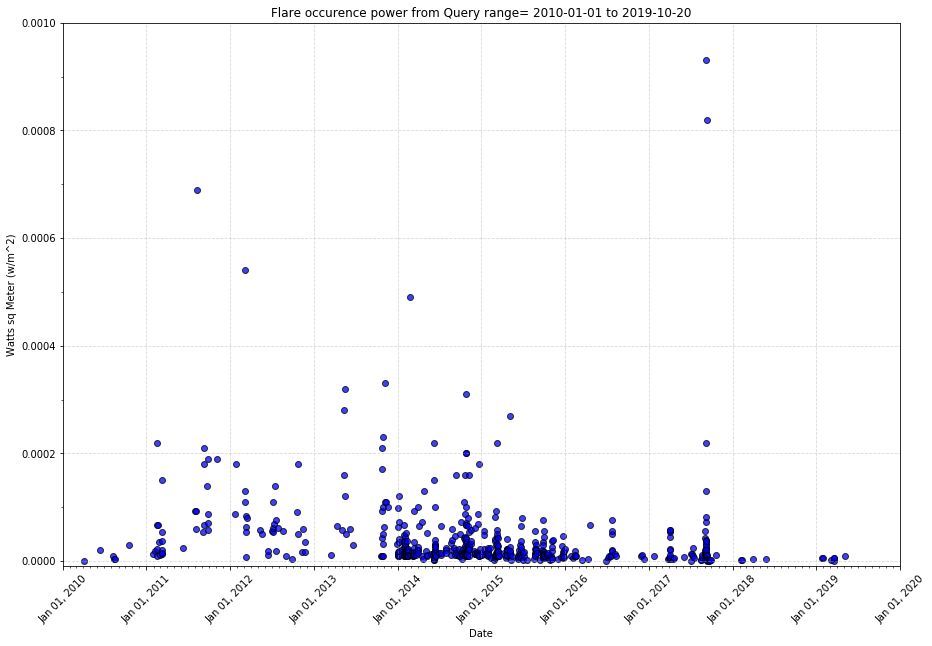

In [43]:
fig, ax = plt.subplots(figsize=(15,10))

ax.scatter(ref_date, power_bin, facecolor = 'b', alpha = .75, edgecolor='k')
ax.set_title(f"Flare occurence power from Query range= {start_date} to {end_date}")
             
             
ax.set_xlabel("Date")
ax.set_xticklabels(ref_date,rotation=45)
ax.set_ylabel("Watts sq Meter (w/m^2)")
ax.set_xlim(dt(2010,1,1), dt(2020,1,1))
ax.set_ylim(-1e-5,10e-4)


years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
fmt = mdates.DateFormatter('%b %d, %Y')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(fmt)
ax.xaxis.set_minor_locator(months)

ax.set_yticks(np.arange(0,11e-4,2e-4))
ax.set_yticks(np.arange(0,10.5e-4,1e-4), minor=True)
ax.grid("--",which='major', alpha=0.5, linestyle='--')